<a href="https://colab.research.google.com/github/UN-GCPDS/Curso-Corto-LLMs/blob/main/1.%20Introducci%C3%B3n/Introducci%C3%B3n_Tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **Introducción Tabnet**

## **Descripción**

Aplicación de modelos de aprendizaje de máquina para el estudio de datos tabulares por métodos supervisados y no supervisados.

### **Profesor - Sesión 1:** Andrés Marino Álvarez Meza y Diego Armando Pérez Rosero

# Datos

**TabNet para criticidad en redes de media tensión — Planteamiento y datos (Regresión)**

Sea el conjunto de datos

$$
\mathbf{X}\in\mathbb{R}^{N\times M},\qquad
\mathbf{y}\in\mathbb{R}^{N}.
$$

Cada fila de $\mathbf{X}$ representa un evento o periodo entre 2019 y 2024 y contiene las características de los elementos asociados al equipo que operó. El vector $\mathbf{y}$ almacena el valor continuo del indicador a modelar (SAIDI o SAIFI) para ese mismo evento/periodo.

Definimos

$$
\mathcal{F}:\mathcal{X}\subseteq\mathbb{R}^{M}\to\mathbb{R},\qquad
\hat{y}=\mathcal{F}(\mathbf{x})
=
\bigl(\,\breve{f}_{L}\circ \breve{f}_{L-1}\circ \cdots \circ \breve{f}_{1}\,\bigr)(\mathbf{x}),
$$

donde $\breve{f}_{l}(\cdot)$ denota el $l$-ésimo bloque del modelo ($l\in\{1,\dots,L\}$) y $\circ$ es el operador de composición.

En caso multisalida para $(\text{SAIDI},\text{SAIFI})$, se toma $\mathcal{F}:\mathbb{R}^{M}\to\mathbb{R}^{2}$ y $\mathbf{y}\in\mathbb{R}^{N\times 2}$.
![Logo UNAL CHEC](https://raw.githubusercontent.com/Daprosero/Deep-Convolutional-Generative-Adversarial-Network/refs/heads/master/Mercados%20CHEC.png)

In [1]:
#@title Librerías
# Instalación de paquetes necesarios
!pip install -q gdown
!pip install openTSNE
!pip install pytorch-tabnet optuna
!pip install wget --quiet

# Importación de librerías necesarias
import optuna
import warnings
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from pytorch_tabnet.augmentations import RegressionSMOTE
from google.colab import drive
import tensorflow as tf
import tensorflow_probability as tfp
import os
from pathlib import Path
import math
import wget
!gdown --id 1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS -O SuperEventos_Criticidad_AguasAbajo_CODEs.zip
!gdown --id 1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ -O model.zip

import zipfile
import os

zip_path = "SuperEventos_Criticidad_AguasAbajo_CODEs.zip"
extract_dir = "CHEC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_path = "model.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
# Supresión de warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning)

# Función auxiliar para etiquetas
def get_labels(x: pd.Series) -> pd.Series:
    labels, _ = pd.factorize(x)
    return pd.Series(labels, name=x.name, index=x.index)

# Definición de funciones personalizadas de pérdida
def my_mse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    return torch.mean(mse_loss)
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_var_band(
    df,
    var_token,
    row_index=0,
    hours_back=24,
    col_patterns=None,
    display_name=None,
    units=None,
    event_label="evento reportado",
):
    """
    Grafica una variable climática en una franja de horas hacia atrás.

    Parámetros
    ----------
    df : pd.DataFrame
        Contiene columnas por hora para la variable elegida.
        Ejemplos de nombres soportados automáticamente:
        - 'h0-<var>', 'h1-<var>', ..., 'h24-<var>'
        - '<var>_h0', '<var>_h1', ...
        con separadores '_' o '-'.

    var_token : str
        Nombre base de la variable en los nombres de columna (p.ej. 'wind_gust_spd',
        'air_temp', 'precip'). Debe coincidir con lo que aparece en las columnas.

    row_index : int
        Fila (evento) a graficar.

    hours_back : int
        Cuántas horas hacia atrás mostrar.

    col_patterns : list[str] | None
        Lista de regex opcionales para detectar columnas por hora.
        Si None, se generan automáticamente a partir de var_token.

    display_name : str | None
        Etiqueta legible para el eje Y (p.ej. 'Ráfaga de viento').
        Si None, se usa var_token.

    units : str | None
        Unidades para concatenar en la etiqueta Y (p.ej. 'm/s', '°C', 'mm').

    event_label : str
        Texto para la flecha en la hora 0.
    """
    # --- 1) Preparar patrones de columnas ---
    if col_patterns is None:
        # Permitir '_' o '-' (o espacio) entre partes del var_token
        parts = re.split(r'[_\-\s]+', var_token.strip())
        # Construimos un regex que tolere '_' o '-' entre partes
        # ej: 'wind[_-]?gust[_-]?spd'
        var_regex = r'[_-]?'.join(map(re.escape, parts))

        col_patterns = [
            rf'^h(\d{{1,2}})[-_]?{var_regex}$',   # h0-<var>  o  h0_<var>
            rf'^{var_regex}[-_]?h(\d{{1,2}})$',   # <var>-h0  o  <var>_h0
        ]

    # --- 2) Detectar columnas y mapear a hora ---
    hour_to_col = {}
    for c in df.columns:
        for pat in col_patterns:
            m = re.match(pat, str(c), flags=re.IGNORECASE)
            if m:
                h = int(m.group(1))
                hour_to_col[h] = c
                break

    if not hour_to_col:
        raise ValueError(
            f"No se encontraron columnas con horas para la variable '{var_token}'.\n"
            f"Prueba ajustando 'var_token' o pasando 'col_patterns' personalizados."
        )

    # --- 3) Construir serie horas [0..hours_back] si existen, orden ascendente ---
    hours = [h for h in sorted(hour_to_col.keys()) if 0 <= h <= hours_back]
    vals = np.array(
        [pd.to_numeric(df.loc[df.index[row_index], hour_to_col[h]], errors='coerce') for h in hours],
        dtype=float
    )

    # --- 4) Graficar ---
    fig, ax = plt.subplots(figsize=(10, 5))

    # línea y puntos
    ax.plot(hours, vals, marker='o')

    # invertir eje X para que se vea 24 -> 0
    ax.set_xlim(hours_back, 0)

    # franja sombreada
    ymin = np.nanmin(vals) if np.isfinite(np.nanmin(vals)) else 0.0
    ymax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 1.0
    pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.axvspan(0, hours_back, alpha=0.15)

    # flecha y etiqueta en hora 0
    y0 = vals[hours.index(0)] if 0 in hours else np.nan
    if not np.isfinite(y0):
        y0 = np.nanmedian(vals) if np.isfinite(np.nanmedian(vals)) else (ymin + ymax) / 2.0

    ax.annotate(
        event_label,
        xy=(0, y0),
        xytext=(max(2, min(4, hours_back*0.15)), y0 + (ymax - y0)*0.15),
        arrowprops=dict(arrowstyle="->", lw=1),
        ha='left', va='bottom'
    )

    # etiquetas
    ylab = display_name if display_name else var_token
    if units:
        ylab = f"{ylab} [{units}]"
    ax.set_xlabel("Horas antes del evento")
    ax.set_ylabel(ylab)
    ax.grid(True, alpha=0.3)

    # ticks principales (24, 18, 12, 6, 0) si corresponde
    xticks = [h for h in [hours_back, 18, 12, 6, 0] if 0 <= h <= hours_back]
    ax.set_xticks(xticks)

    plt.tight_layout()
    plt.show()


# --- Ejemplo de uso:
# plot_wind_gust_band(df=tu_dataframe, row_index=0, hours_back=24)

def my_rmse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    mean_mse_loss = torch.mean(mse_loss)
    rmse_loss = torch.sqrt(mean_mse_loss)
    return rmse_loss

def my_mae_loss_fn(y_pred, y_true):
    mae_loss = torch.abs(y_true - y_pred)
    return torch.mean(mae_loss)

def my_mape_loss_fn(y_pred, y_true):
    mape_loss = torch.abs((y_true - y_pred) / y_true) * 100
    return torch.mean(mape_loss)

def my_r2_score_fn(y_pred, y_true):
    total_variance = torch.var(y_true, unbiased=False)
    unexplained_variance = torch.mean((y_true - y_pred) ** 2)
    r2_score = 1 - (unexplained_variance / total_variance)
    return 1-r2_score
class CustomTabNetRegressor(TabNetRegressor):
    def __init__(self, *args, **kwargs):
        super(CustomTabNetRegressor, self).__init__(*args, **kwargs)

    def forward(self, X):
        output, M_loss = self.network(X)
        output = torch.relu(output)
        return output, M_loss

    def predict(self, X):
        device = next(self.network.parameters()).device
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X = X.to(device)
        with torch.no_grad():
            output, _ = self.forward(X)
        return output.cpu().numpy()
# Etapa 0: imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
# ==== Librerías ====
import numpy as np
import cupy as cp
import xgboost as xgb

from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.metrics import r2_score as r2_gpu

# Si quieres comparar con CPU para sanity-check:
from sklearn.metrics import r2_score as r2_cpu
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
# ==== Utilidades ====
def to_cpu(a):
    """Convierte CuPy -> NumPy si aplica."""
    try:
        if isinstance(a, cp.ndarray):
            return cp.asnumpy(a)
    except Exception:
        pass
    return a

def metrics_gpu(y_true_cp, y_pred_cp):
    """MAE, RMSE, R2 calculados en GPU (CuPy)."""
    y_true_cp = cp.asarray(y_true_cp)
    y_pred_cp = cp.asarray(y_pred_cp)
    mae  = float(cp.mean(cp.abs(y_true_cp - y_pred_cp)))
    rmse = float(cp.sqrt(cp.mean((y_true_cp - y_pred_cp)**2)))
    ssr  = float(cp.sum((y_true_cp - y_pred_cp)**2))
    sst  = float(cp.sum((y_true_cp - cp.mean(y_true_cp))**2))
    r2   = 1.0 - ssr / sst if sst > 0 else np.nan
    return mae, rmse, r2

def permutation_importance_rf_gpu(model, X_val_cp, y_val_cp, n_repeats=3, max_feats=None, random_state=42):
    """
    Permutation importance en GPU para RF cuML.
    Devuelve importancia por feature (drop medio de R2 en valid).
    Si max_feats no es None, calcula solo para las primeras max_feats columnas (para acelerar).
    """
    rs = cp.random.RandomState(random_state)
    X_val_cp = cp.asarray(X_val_cp)
    y_val_cp = cp.asarray(y_val_cp)

    # R2 base
    y_pred_base = model.predict(X_val_cp)
    _, _, r2_base = metrics_gpu(y_val_cp, y_pred_base)

    n, d = X_val_cp.shape
    d_eval = d if max_feats is None else int(min(max_feats, d))
    importances = cp.zeros(d, dtype=cp.float32)

    for j in range(d_eval):
        drops = []
        for _ in range(n_repeats):
            Xp = X_val_cp.copy()
            idx = rs.permutation(n)
            Xp[:, j] = Xp[idx, j]  # permutar solo la columna j
            y_pred_p = model.predict(Xp)
            _, _, r2_p = metrics_gpu(y_val_cp, y_pred_p)
            drops.append(r2_base - r2_p)
        importances[j] = cp.mean(cp.asarray(drops))

    return importances  # CuPy array
def regression_metrics(y_true, y_pred):
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mae, rmse, r2



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS
From (redirected): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS&confirm=t&uuid=a8be4c30-7a7f-47bb-8a16-2087b8e62a91
To: /content/SuperEventos_Criticidad_AguasAbajo_CODEs.zip
100% 214M/214M [00:03<00:00, 56.6MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id`

## Construcción de $\mathbf{X}$

In [2]:
Xdata = df = pd.read_pickle('/content/CHEC/SuperEventos_Criticidad_AguasAbajo_CODEs.pkl')
Xdata = Xdata[Xdata['duracion_h'] <= 100]


In [3]:
Xdata.head()

,evento,equipo_ope,tipo_equi_ope,cto_equi_ope,tipo_elemento,inicio,fin,duracion_h,tipo_duracion,causa,...,conteo_vegetacion,nombre_comun_mas_frecuente,CODE,TIPO,CLASE,MATERIAL,LONG_APOYO,TIERRA_PIE,VIENTOS,TRAMOS_AGUAS_ABAJO_CODES
0,7549809,MAZ30L13,interruptor,MAZ30L13,33,2019-01-01 00:00:01,2019-01-01 01:01:49,1.030000,> 3 min,Falla en postes y/o crucetas en el SDL,...,1,MANZANILLO,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
1,7549809,MAZ30L13,interruptor,MAZ30L13,33,2019-01-01 00:00:01,2019-01-01 01:09:36,1.159722,> 3 min,Falla en postes y/o crucetas en el SDL,...,1,MANZANILLO,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
2,7549809,MAZ30L13,interruptor,MAZ30L13,33,2019-01-01 00:00:01,2019-01-01 01:18:21,1.305556,> 3 min,Falla en postes y/o crucetas en el SDL,...,1,MANZANILLO,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
3,7549809,MAZ30L13,interruptor,MAZ30L13,33,2019-01-01 00:00:01,2019-01-01 02:41:00,2.683056,> 3 min,Falla en postes y/o crucetas en el SDL,...,1,MANZANILLO,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
4,7549809,MAZ30L13,interruptor,MAZ30L13,33,2019-01-01 00:00:01,2019-01-01 13:22:25,13.373333,> 3 min,Falla en postes y/o crucetas en el SDL,...,1,MANZANILLO,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."


In [4]:
Xdata[['inicio_evento', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA',
            'LONGITUD2', 'LATITUD2','ORDER_']].head()

,inicio_evento,evento,fin,inicio,cnt_usus,DEP,MUN,FECHA,LONGITUD2,LATITUD2,ORDER_
0,2019-01-01 00:00:01,7549809,2019-01-01 01:01:49,2019-01-01 00:00:01,1.0,CALDAS,MANZANARES,2019-01,NaN,NaN,NaN
1,2019-01-01 00:00:01,7549809,2019-01-01 01:09:36,2019-01-01 00:00:01,325.0,CALDAS,MANZANARES,2019-01,NaN,NaN,NaN
2,2019-01-01 00:00:01,7549809,2019-01-01 01:18:21,2019-01-01 00:00:01,3015.0,CALDAS,MANZANARES,2019-01,NaN,NaN,NaN
3,2019-01-01 00:00:01,7549809,2019-01-01 02:41:00,2019-01-01 00:00:01,2498.0,CALDAS,MANZANARES,2019-01,NaN,NaN,NaN
4,2019-01-01 00:00:01,7549809,2019-01-01 13:22:25,2019-01-01 00:00:01,3.0,CALDAS,MANZANARES,2019-01,NaN,NaN,NaN


In [5]:
Xdata[['DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES']].head()

,DEP,MUN,FECHA,NIVEL_C,VALOR_C,TRAMOS_AGUAS_ABAJO,EQUIPOS_PUNTOS,PUNTOS_POLIGONO,FECHA_C,TRAMOS_AGUAS_ABAJO_CODES
0,CALDAS,MANZANARES,2019-01,0,0.0,"[(5.270351285056272, -75.12184704794859), (5.2...","[(5.279440126576255, -75.09663447048119), (5.2...","[(5.26300304370033, -75.14657420539724), (5.26...",2019-01,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
1,CALDAS,MANZANARES,2019-01,3,0.0,"[(5.270351285056272, -75.12184704794859), (5.2...","[(5.279440126576255, -75.09663447048119), (5.2...","[(5.26300304370033, -75.14657420539724), (5.26...",2019-01,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
2,CALDAS,MANZANARES,2019-01,3,0.0,"[(5.270351285056272, -75.12184704794859), (5.2...","[(5.279440126576255, -75.09663447048119), (5.2...","[(5.26300304370033, -75.14657420539724), (5.26...",2019-01,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
3,CALDAS,MANZANARES,2019-01,3,0.0,"[(5.270351285056272, -75.12184704794859), (5.2...","[(5.279440126576255, -75.09663447048119), (5.2...","[(5.26300304370033, -75.14657420539724), (5.26...",2019-01,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."
4,CALDAS,MANZANARES,2019-01,1,0.0,"[(5.270351285056272, -75.12184704794859), (5.2...","[(5.279440126576255, -75.09663447048119), (5.2...","[(5.26300304370033, -75.14657420539724), (5.26...",2019-01,"{'B2445', 'B2453', 'B2450', 'B2464', 'B2449', ..."


In [6]:

# Extraer variables objetivo
Dur_h = Xdata['duracion_h'].values
SAIDI = Xdata['SAIDI'].values
df1=Xdata.copy()
# Eliminar columnas no utilizadas
Xdata.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)

# Definir la variable objetivo y eliminarla del conjunto de características
target = ['SAIFI', 'SAIDI', 'duracion_h']
y1 = Xdata[target].values
Xdata.drop(target, axis=1, inplace=True)

### Integración de tablas

$\mathbf{X}$ se construye a partir de la **integración horizontal** de varias tablas unidas por claves operativas (p. ej., *evento*, *equipo\_ope*, *tipo\_elemento*, *alimentador*).
Las **columnas 1–7** de $\mathbf{X}$ provienen de la tabla **EVENTOS** (2019–jun/2024).




In [7]:
Xdata.iloc[:,0:7]

,equipo_ope,tipo_equi_ope,cto_equi_ope,tipo_elemento,tipo_duracion,causa,CNT_TRAFOS_AFEC
0,MAZ30L13,interruptor,MAZ30L13,33,> 3 min,Falla en postes y/o crucetas en el SDL,1.0
1,MAZ30L13,interruptor,MAZ30L13,33,> 3 min,Falla en postes y/o crucetas en el SDL,32.0
2,MAZ30L13,interruptor,MAZ30L13,33,> 3 min,Falla en postes y/o crucetas en el SDL,54.0
3,MAZ30L13,interruptor,MAZ30L13,33,> 3 min,Falla en postes y/o crucetas en el SDL,209.0
4,MAZ30L13,interruptor,MAZ30L13,33,> 3 min,Falla en postes y/o crucetas en el SDL,1.0
...,...,...,...,...,...,...,...
166318,M24083,interruptor,VMA23L15,13.2,> 3 min,Causa desconocida,6.0
166319,M24081,transformador,VMA23L15,TFD,> 3 min,Causa desconocida,1.0
166320,VBO23L14,interruptor,VBO23L14,13.2,<= 3 min,Condiciones atmosféricas,168.0
166321,VBO23L14,interruptor,VBO23L14,13.2,<= 3 min,Condiciones atmosféricas,23.0


Las **columnas 7–14** de $\mathbf{X}$ provienen de la tabla **SWITCHES** (2019/2024).

Preprocesamiento: filtro por niveles $KV$ propios de MT ($\leq 33\,\text{kV}$); mapeo de `PHASES` mediante diccionario; normalización de `ASSEMBLY` (códigos → descripciones); mapeo de `STATE` a etiquetas (“Normalmente abierto/cerrado”); tipificación de `FECHA` a `datetime64[ns]`; imputación de `ASSEMBLY` vacío usando el último registro del mismo `CODE` con `ASSEMBLY` no vacío.



In [8]:
Xdata.iloc[:,7:15]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ASSEMBLY,PHASES,FPARENT,KV,STATE,LINESECTIO,LONGITUD,LATITUD
0,3IG,3.0,MAZ30L13,33.000000,Normalmente cerrado,B2443,-75.146304,5.263121
1,3IG,3.0,MAZ30L13,33.000000,Normalmente cerrado,B2443,-75.146304,5.263121
2,3IG,3.0,MAZ30L13,33.000000,Normalmente cerrado,B2443,-75.146304,5.263121
3,3IG,3.0,MAZ30L13,33.000000,Normalmente cerrado,B2443,-75.146304,5.263121
4,3IG,3.0,MAZ30L13,33.000000,Normalmente cerrado,B2443,-75.146304,5.263121
...,...,...,...,...,...,...,...,...
166318,Cortacircuito trifásico con cámara romperarco,3.0,VMA23L15,13.203125,Normalmente cerrado,26562,-75.518162,5.042200
166319,AT112V00,1.0,VMA23L15,NaN,NaN,NaN,-75.518184,5.042223
166320,3IG,3.0,VBO23L14,13.203125,Normalmente cerrado,42012,-75.848670,5.065073
166321,3IG,3.0,VBO23L14,13.203125,Normalmente cerrado,42012,-75.848670,5.065073


Las **columnas 15–25** de $\mathbf{X}$ provienen de la tabla **TRAFOS** (2019/2024).
Preprocesamiento: mapeo de `PHASES` para uniformidad; codificación de `OWNER1` a {`C`,`P`}; actualización de `TIPO_SUB` con descripciones normalizadas; conversión de `DATE_FAB`, `DATE_INST` y `DATE_REM` a `datetime64[ns]` con imputación controlada de nulos; cálculo de `FECHA_ACT = \max(\text{DATE_REM},\text{DATE_INST})` y posterior eliminación de las columnas de fecha originales; unión con **Parámetros\_varios.xlsx** para enriquecer con `KVA` y `KV`, excluyendo registros no pertinentes.

In [9]:
Xdata[~Xdata['MARCA'].isna()].iloc[:,15:26]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,OWNER1,TRFTYPE,ELNODE,IMPEDANCE,DATE_FAB,MARCA,TIPO_SUB,GRUPO015,FECHA_ACT,KVA,KV1
14,C,2T5.0_1_240,O23523,3.000000,2017-03-07,RYM,Subestaciones de distribución tipo poste,32.0,2017-07-04 00:00:00,5.0,7.621
16,C,2T5.0_2_240,L13557,2.300781,2005-01-01,MAG,Subestaciones de distribución tipo poste,33.0,2005-10-14 00:00:00,5.0,13.200
20,C,2T15.0_1_240,W10256,2.599609,2004-01-01,MAG,Subestaciones de distribución tipo poste,32.0,2004-09-18 00:00:00,15.0,7.621
22,C,2T25.0_1_240,W55768,3.000000,2017-02-01,MAG,Subestaciones de distribución tipo poste,33.0,2017-12-09 00:00:00,25.0,7.621
23,C,2T10.0_1_240,O23660,3.000000,2010-01-01,MAG,Subestaciones de distribución tipo poste,32.0,1899-12-30 00:00:00,10.0,7.621
...,...,...,...,...,...,...,...,...,...,...,...
166309,C,2T10.0_1_240,E12352,2.500000,NaN,MAG,Subestaciones de distribución tipo poste,33.0,2023-02-13 08:40:11,10.0,7.621
166310,C,2T10.0_2_240,L11309,2.500000,NaN,MAG,Subestaciones de distribución tipo poste,33.0,2015-01-01 00:00:00,10.0,13.200
166312,C,2T37.5_2_240,D14083,2.019531,NaN,TPL,Subestaciones de distribución tipo poste,33.0,2015-01-08 00:00:00,37.5,13.200
166316,C,2T30.0_3_226,N10147,3.000000,NaN,MAG,Subestaciones de distribución tipo poste,22.0,2009-08-18 00:00:00,30.0,13.200



Las **columnas 26–48** de $\mathbf{X}$ provienen de la tabla REDMT (2019–jun/2024).
Preprocesamiento: filtro por $\text{KVNOM} \le 33\,\text{kV}$; mapeo de `PHASES`; unión con *Parámetros\_varios.xlsx* para `MATERIALCONDUCTOR`, `TIPOCONDUCTOR`, `CALIBRECONDUCTOR` y neutral; normalización de `OWNER` (p. ej., a {C, P}); conversión de fechas a `datetime64[ns]` con imputación controlada; cálculo de `FECHA_ACT` como máximo entre fechas; incorporación de propiedades eléctricas (p. ej., resistencia \[$\Omega/\text{km}$] y capacidad).


In [10]:
Xdata[~Xdata['CONDUCTOR'].isna()].iloc[:,26:49]

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ELNODE1,ELNODE2,CONDUCTOR,NEUTRAL,LENGTH,KVNOM,CLASS,TOWNER,MATERIALCONDUCTOR,TIPOCONDUCTOR,...,NEUTRO_SECUNDARIOCONDUCTOR,NIVEL1CONDUCTOR,NIVEL2CONDUCTOR,NIVEL3CONDUCTOR,NIVEL4CONDUCTOR,ACOMETIDACONDUCTOR,NEUTRO,CALIBRENEUTRO,CAPACITY,RESISTANCE
54,E55012,E55105,5A-0624,5A-0624,13.000000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,184.0,0.89095
801,M20001,M21002,5A-0624,5A-0626,46.000000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1/0,184.0,0.89095
812,W42412,W42850,5A-0624,No aplica,10.398438,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,No aplica,No aplica,184.0,0.89095
813,W11977,W11978,5A-0624,5A-0624,319.250000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,184.0,0.89095
1106,N42274,N42275,5A-0624,5A-0624,22.203125,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,184.0,0.89095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164399,N21008,N21009,5A-0624,5A-0624,30.500000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,184.0,0.89095
164965,C20047,C20048,5A-0628,No aplica,126.500000,13.203125,0.0,P,ACSR,DESNUDO,...,1.0,1.0,1.0,1.0,0.0,0.0,No aplica,No aplica,275.0,0.46476
165497,W33159,W33162,5A-0622,No aplica,171.250000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,1.0,No aplica,No aplica,139.0,1.39265
165756,C31734,C31854,5A-0624,5A-0624,88.000000,13.203125,0.0,C,ACSR,DESNUDO,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2,184.0,0.89095



Las **columnas 49–290** de $\mathbf{X}$ provienen de una integración climática vía [API](https://www.weatherbit.io/pricing), enlazando cada evento con series horarias del lugar más cercano en el intervalo $[t-24\text{h},\,t]$. Se realiza unión espacio–temporal por coordenadas y marca de tiempo del evento, conversión y homogeneización de unidades, interpolación controlada de vacíos y estandarización de nombres.
![texto del vínculo](https://raw.githubusercontent.com/Daprosero/Deep-Convolutional-Generative-Adversarial-Network/refs/heads/master/Api.png)
Ingeniería de variables:

* Precipitación (precip): Relacionada con riesgos de humedad en componentes eléctricos y sistemas de puesta a tierra.
* Presión Atmosférica (pres): Relevante en altitudes elevadas, donde afecta la disipación térmica y rigidez dieléctrica.
* Humedad Relativa (rh): Indicador crítico para corrosión y descargas parciales.
* Presión a Nivel del Mar (slp): Complementa el análisis de presión local y su impacto en equipos sensibles.
* Radiación Solar (solar\_rad): Influye en el desgaste de materiales expuestos a luz solar.
* Temperatura Ambiente (temp): Afecta el desempeño térmico y la vida útil de transformadores y conductores.
* Índice UV (uv): Determina el deterioro acelerado de materiales poliméricos.
* Visibilidad (vis): Información relevante para planificar actividades de mantenimiento.
* Ráfagas de Viento (wind\_gust\_spd): Relacionadas con cargas mecánicas adicionales en apoyos y conductores.
* Velocidad Promedio del Viento (wind\_spd): Afecta el diseño mecánico y estabilidad de líneas aéreas.

Resolución temporal (según endpoint activado)
* actual: ahora/hora más reciente (con campos como temperatura, punto de rocío, humedad, presión, viento, nubosidad, precipitación, visibilidad, radiación, UV, AQI).
* histórico: diario, horario y sub-horario (15 min); permite construir ventanas 6/12/24 h y normales climáticas.

Resolución espacial
* cobertura global con modelos y observaciones fusionadas; resolución de malla típica de 1–13 km en pronóstico (según modelo fuente).
![texto del vínculo](https://scontent.fclo9-1.fna.fbcdn.net/v/t39.30808-6/530222992_1186925020119015_6505934253769617645_n.jpg?_nc_cat=100&ccb=1-7&_nc_sid=127cfc&_nc_ohc=V4MjVx6GticQ7kNvwF1D6qh&_nc_oc=AdlzHM7VoVz8R3wh0F8om0fdnquIGhvSP89mogkrBfTZliTlEIxNq4luYXIcul4VCD0&_nc_zt=23&_nc_ht=scontent.fclo9-1.fna&_nc_gid=8G4jnFmzMoCjRmftnfn4-w&oh=00_AfV87fJieLT103xrJJLytrj1bhu67_-nj0lFg6F5R78AyQ&oe=68A19B3E)

Precisión, cobertura y control de calidad
* históricos con backfilling y cobertura garantizada del 99.95% en parámetros clave (temperatura, punto de rocío, humedad, viento, nubosidad, radiación, precipitación, nieve), integrando estaciones, radar, satélite.
* recomendaciones de uso: validar unidades (p. ej., mm vs in, W/m² vs kWh/m²), convertir todos los sellos a UTC, y aplicar chequeos básicos (rangos físicos, outliers, huecos).



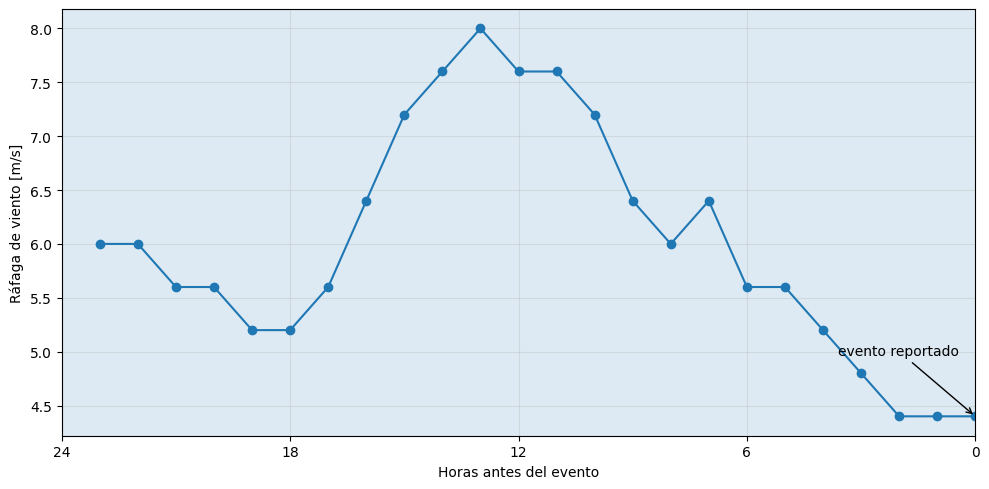

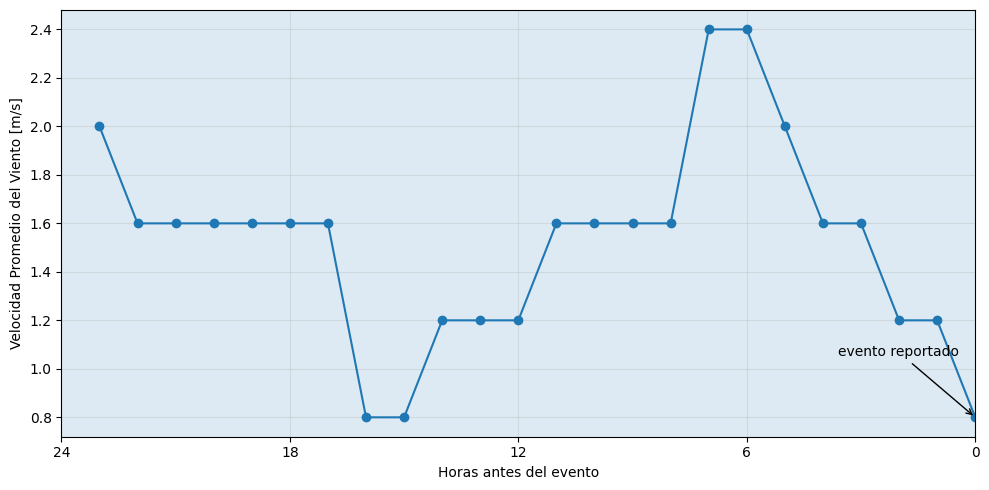

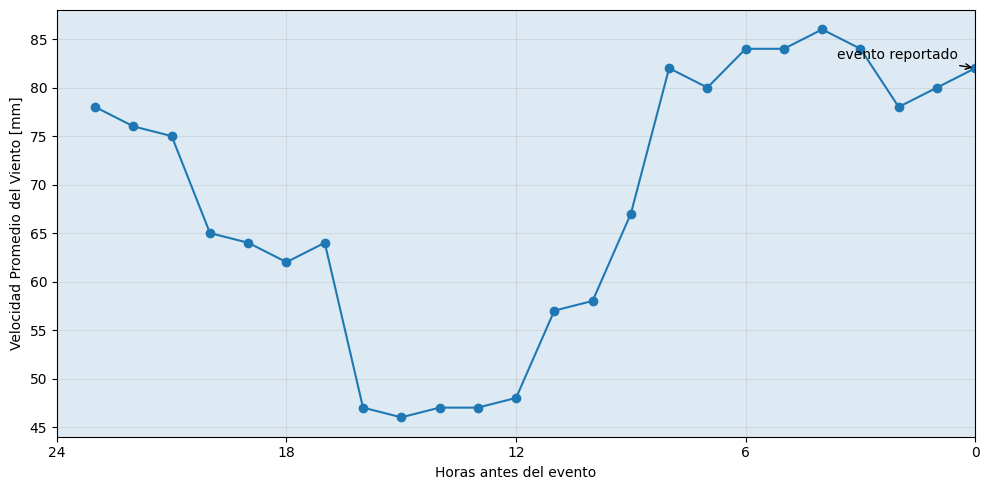

In [11]:
#plot_wind_gust_band(Xdata, row_index=0, hours_back=24)

# 1) Mis columnas son del estilo h0-wind_gust_spd, h1-wind_gust_spd, ...
plot_var_band(df, var_token="wind_gust_spd",
              row_index=0, hours_back=24,
              display_name="Ráfaga de viento", units="m/s")

# 2) Mis columnas son del estilo air_temp_h0, air_temp_h1, ...
plot_var_band(df, var_token="wind_spd",
              row_index=0, hours_back=24,
              display_name="Velocidad Promedio del Viento", units="m/s")

plot_var_band(df, var_token="rh",
              row_index=0, hours_back=24,
              display_name="Velocidad Promedio del Viento", units="mm")



In [12]:
Xdata[~Xdata['CONDUCTOR'].isna()].iloc[:,49:291]

,h0-clouds,h0-precip,h0-pres,h0-rh,h0-slp,h0-temp,h0-vis,h0-wind_gust_spd,h0-wind_spd,h1-clouds,...,h22-wind_spd,h23-clouds,h23-precip,h23-pres,h23-rh,h23-slp,h23-temp,h23-vis,h23-wind_gust_spd,h23-wind_spd
54,5.0,0.00,911.0,63.0,1010.0,16.700001,10.0,5.20,2.00,4.0,...,1.20,48.0,0.00,912.0,55.0,1010.0,18.900000,10.0,6.0,1.20
801,45.0,0.00,818.0,86.0,1017.0,13.300000,10.0,5.20,1.60,50.0,...,1.20,75.0,0.00,820.0,87.0,1017.0,15.900000,10.0,4.4,1.20
812,71.0,0.50,891.0,93.0,1015.0,16.700001,10.0,3.60,0.80,77.0,...,0.00,80.0,0.00,892.0,89.0,1015.0,20.000000,10.0,2.0,0.40
813,71.0,0.50,855.0,93.0,1015.0,16.700001,10.0,3.60,0.80,77.0,...,0.00,80.0,2.00,857.0,89.0,1015.0,20.000000,10.0,2.0,0.40
1106,22.0,0.00,842.0,83.0,1016.0,18.100000,10.0,4.80,1.20,21.0,...,2.00,6.0,0.00,840.0,85.0,1015.0,16.700001,10.0,6.8,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164399,97.0,0.50,809.0,93.0,1018.0,14.400000,7.0,3.20,0.40,99.0,...,0.00,100.0,13.00,811.0,98.0,1020.0,14.100000,7.0,3.2,0.00
164965,100.0,1.50,900.0,98.0,1015.0,16.700001,10.0,4.00,0.80,100.0,...,0.00,98.0,2.50,899.0,89.0,1014.0,18.500000,10.0,3.2,0.80
165497,100.0,2.75,865.0,95.0,1016.0,15.900000,8.0,2.80,0.80,100.0,...,1.20,99.0,8.00,866.0,95.0,1016.0,17.799999,8.0,2.4,0.80
165756,100.0,5.50,902.0,98.0,1015.0,17.799999,10.0,4.80,0.80,100.0,...,0.00,100.0,1.75,904.0,89.0,1017.0,17.799999,10.0,1.6,0.00



**Bloque: Rayos/descargas**
Asociación espaciotemporal por evento en $[t-24\text{ h},\, t]$ y por municipio; búsqueda espacial alrededor de los **tramos aguas abajo** usando KDTree con radio $r=0.005^\circ$ (557 m). Se calculan estadísticos de **ALTITUD** y **CORRIENTE** (valor absoluto), y conteos por **TIPO**.

**Columnas 291–302**

* `ALTITUD_mean`, `ALTITUD_median`, `ALTITUD_min`, `ALTITUD_max`, `ALTITUD_std`
* `CORRIENTE_mean`, `CORRIENTE_median`, `CORRIENTE_min`, `CORRIENTE_max`, `CORRIENTE_std`
* `TIPO_1_count`, `TIPO_2_count`

**Notas**

* Si no hay rayos en la ventana: todas las columnas → `NaN`.
* Si hay un solo valor: `*_std = 0`.
* `CORRIENTE` se toma en valor absoluto.

1. Construir **KDTree por municipio** con coordenadas $(\text{LATITUD},\text{LONGITUD})$.
2. Para cada evento:

   * Filtrar rayos del municipio en $[t-24\text{ h},\, t]$.
   * Crear KDTree temporal y **buscar vecinos** de cada punto en `TRAMOS_AGUAS_ABAJO` con $r=0.005^\circ$.
   * Agregar estadísticos y conteos de `TIPO` (1 y 2).
3. Concatenar el **DataFrame de resultados** a `Eventos` preservando el índice.



In [13]:
Xdata[(Xdata['ALTITUD_mean']!=0)&~Xdata['ALTITUD_mean'].isna()].iloc[:,291:303]

,ALTITUD_mean,ALTITUD_median,ALTITUD_min,ALTITUD_max,ALTITUD_std,CORRIENTE_mean,CORRIENTE_median,CORRIENTE_min,CORRIENTE_max,CORRIENTE_std,TIPO_1_count,TIPO_2_count
5926,0.028278,0.0,0.0,11.0,0.557722,6.647301,5.50,2.3,25.400000,3.440177,386.0,3.0
6009,0.029178,0.0,0.0,11.0,0.566529,6.665782,5.50,2.3,25.400000,3.493082,374.0,3.0
6027,0.294737,0.0,0.0,11.2,1.816880,7.400000,6.60,3.3,14.500000,2.986094,37.0,1.0
6059,0.208594,0.0,0.0,14.2,1.665586,10.585938,7.80,3.1,53.400002,8.092786,125.0,3.0
6107,1.420000,0.0,0.0,14.2,4.490434,7.780000,6.35,3.9,19.799999,4.643945,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
166303,5.842857,0.0,0.0,14.4,7.310234,28.242857,12.10,6.8,79.099998,29.210093,4.0,3.0
166304,5.842857,0.0,0.0,14.4,7.310234,28.242857,12.10,6.8,79.099998,29.210093,4.0,3.0
166305,5.842857,0.0,0.0,14.4,7.310234,28.242857,12.10,6.8,79.099998,29.210093,4.0,3.0
166306,5.842857,0.0,0.0,14.4,7.310234,28.242857,12.10,6.8,79.099998,29.210093,4.0,3.0



**Bloque: Vegetación**
Vinculación espacial por municipio mediante KDTree con radio $r=0.0003^\circ$ ( 33 m) alrededor de los **tramos aguas abajo** de cada evento.

**Columnas 303–304**

* `conteo_vegetacion` (entero): número de registros de vegetación cercanos al tramo.
* `nombre_comun_mas_frecuente` (texto): **modo** de `NOM_COMUN` entre los puntos encontrados.

**Notas**

* Sin puntos cercanos: `conteo_vegetacion = 0`, `nombre_comun_mas_frecuente = NaN`.
* Valores como `NN` pueden aparecer si la fuente no registra nombre común.

Procedimiento (vegetación)

1. Construir **KDTree por municipio** con coordenadas de la tabla de vegetación.
2. Para cada evento:

   * Consultar vecinos de `TRAMOS_AGUAS_ABAJO` con $r=0.0003^\circ$.
   * Calcular `conteo_vegetacion` y el **modo** de `NOM_COMUN`.
3. Formar un DataFrame con ambas columnas y **unir por índice** a `Eventos`.


In [14]:
Xdata[~Xdata['nombre_comun_mas_frecuente'].isna()].iloc[:,303:305]#[(Xdata['ALTITUD_mean']!=0)&~Xdata['ALTITUD_mean'].isna()]

,conteo_vegetacion,nombre_comun_mas_frecuente
0,1,MANZANILLO
1,1,MANZANILLO
2,1,MANZANILLO
3,1,MANZANILLO
4,1,MANZANILLO
...,...,...
166314,7,NN
166316,2,CARBONERO ROJO
166320,63,MATARRATON
166321,63,MATARRATON



Las últimas 7 columnas de $\mathbf{X}$ provienen de la tabla APOYOS. El preprocesamiento incluye: conversión de FECHA a dato temporal; mapeo de MATERIAL mediante diccionario (por ejemplo, “B” → “Tubo metálico”, “T” → “Poste en concreto”); unión con la hoja Parámetros\_varios.xlsx para completar TIPO, CLASE y otros atributos; asignación de longitudes predeterminadas en LONG\_APOYO para valores específicos de ASSEMBLY (FICTICIO, PORTICO, FACHADA); imputación de TOWNER con “C” cuando está vacío; conversión de VIEN\_SEC a numérico y mapeo de VIEN\_PRIM, a partir de los cuales se construye la variable VIENTOS.

In [15]:
Xdata.iloc[:,305:]#[(Xdata['ALTITUD_mean']!=0)&~Xdata['ALTITUD_mean'].isna()]

,CODE,TIPO,CLASE,MATERIAL,LONG_APOYO,TIERRA_PIE,VIENTOS
0,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0
1,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0
2,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0
3,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0
4,E31001,A,F,Torrecilla metálica triangular,12.0,0,3.0
...,...,...,...,...,...,...,...
166318,M24081,A,F,Poste en Concreto,12.0,0,0.0
166319,M24081,A,F,Poste en Concreto,12.0,0,0.0
166320,VBO40_30,E,F,No aplica,10.0,No aplica,No aplica
166321,VBO40_30,E,F,No aplica,10.0,No aplica,No aplica




## Procesamiento
**Objetivo:** dejar listas $\mathbf{X}$ y $\mathbf{y}$ para TabNet (regresión), con estratificación auxiliar.

**Etapas**

1. **Seleccionar objetivo**: tomar $y$ (SAIDI/SAIFI) con forma $(N,1)$.
2. **Tipificar columnas**: separar numéricas y categóricas de `Xdata`.
3. **Imputación numérica**: rellenar `NaN` con $-10\times\max(\text{col})$ (o 0 si la columna es toda `NaN`).
4. **Codificación categórica**: `LabelEncoder` por columna; guardar diccionarios y cardinalidades.
5. **Construir matrices**: lista de *features* y creación de $\mathbf{X}\in\mathbb{R}^{N\times M}$, $\mathbf{y}\in\mathbb{R}^{N\times 1}$.
6. **Etiquetas para estratificación**: clases a partir de percentiles del objetivo (o usar `df1['NIVEL_C']` si existe).
7. **Escalado del objetivo**: `MinMaxScaler` sobre $\mathbf{y}$ (regresión).
8. **Split**:

   * Train/Test con `stratify` en las clases auxiliares.
   * Train/Valid (20%) estratificando por percentiles de $y_{\text{train}}$.

In [16]:
# ---------------------------------------------------------
# Etapa 1: seleccionar objetivo (SAIDI o SAIFI) con forma (N,1)
y = y1[:, 0:1].astype('float32')

# Copia de trabajo de X
df = Xdata.copy()

# ---------------------------------------------------------
# Etapa 2: tipificar columnas
NUMERIC_COLUMNS = df.select_dtypes(include=['number']).columns.tolist()
CATEGORICAL_COLUMNS = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ---------------------------------------------------------
# Etapa 3: imputación numérica
max_values = {}
for col in NUMERIC_COLUMNS:
    max_value = pd.to_numeric(df[col], errors='coerce').max()
    if pd.isna(max_value):
        max_value = 0.0
    max_values[col] = max_value
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-10.0 * max_value)

# ---------------------------------------------------------
# Etapa 4: codificación categórica
label_encoders = {}
categorical_dims = {}
for col in CATEGORICAL_COLUMNS:
    enc = LabelEncoder()
    s = df[col].astype(str).fillna("no aplica")
    enc.fit(s)
    df[col] = enc.transform(s)
    label_encoders[col] = enc
    categorical_dims[col] = len(enc.classes_)

# ---------------------------------------------------------
# Etapa 5: construir matrices X, y
unused_feat = []
# Si Xdata NO incluye el target, basta con tomar todas las columnas
features = [c for c in df.columns if c not in unused_feat]
X = df[features].values.astype('float32')

# ---------------------------------------------------------
# Etapa 6: clases auxiliares para estratificación
try:
    # usar etiqueta externa si existe
    y_categorized = df1['NIVEL_C'].values.astype(int)
except Exception:
    # fallback: terciles del objetivo
    percentiles = np.percentile(y[:, 0], [33.33, 66.66])
    y_categorized = np.digitize(y[:, 0].flatten(), bins=percentiles).astype(int)

# ---------------------------------------------------------
# Etapa 7: escalar objetivo (regresión)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# ---------------------------------------------------------
# Etapa 8: split train/test estratificado
X_train, X_test, y_train, y_test, ycat_train, ycat_test = train_test_split(
    X, y_scaled, y_categorized, test_size=0.20, random_state=42, stratify=y_categorized
)

# Etapa 8b: split train/valid estratificado por percentiles de y_train
percentiles_t = np.percentile(y_train[:, 0], [25, 50, 75])
y_categorized_t = np.digitize(y_train[:, 0].flatten(), bins=percentiles_t).astype(int)

X_train, X_valid, y_train, y_valid, ycat_train, ycat_valid = train_test_split(
    X_train, y_train, ycat_train, test_size=0.20, random_state=42, stratify=y_categorized_t
)

# Comprobaciones rápidas
print(X.shape, y.shape)
print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)
print("Train/Valid/Test:", y_train.shape, y_valid.shape, y_test.shape)

(166323, 312) (166323, 1)
Train/Valid/Test: (106446, 312) (26612, 312) (33265, 312)
Train/Valid/Test: (106446, 1) (26612, 1) (33265, 1)


# Modelos

![Logo UNAL CHEC](https://catalog.ngc.nvidia.com/_next/image?url=https%3A%2F%2Fassets.nvidiagrid.net%2Fngc%2Flogos%2FOSS-Nvidia-Partnership-Rapids.png&w=828&q=90)


**RAPIDS** es un ecosistema de NVIDIA que replica APIs de *pandas/scikit-learn* en GPU (cuDF, cuML, CuPy), permitiendo ejecutar **preprocesamiento** y **modelos** en la misma memoria de la GPU. Para este proyecto (regresión de SAIDI/SAIFI con millones de filas y decenas–centenas de variables), esto aporta:

* **Aceleración efectiva**: entrenamientos y predicciones con cuML (**RandomForest**) y XGBoost en GPU reducen tiempos de minutos/horas a segundos/minutos (según tamaño del dataset y GPU), facilitando *grid search* y validaciones repetidas.
* **Menos copias CPU↔GPU**: mover $\mathbf{X}$ y $\mathbf{y}$ una sola vez a GPU (CuPy/cuDF) evita cuellos de botella y mantiene el *pipeline* end-to-end en dispositivo.
* **Escalabilidad y memoria**: el *pool* de memoria de **RMM** disminuye la fragmentación y estabiliza cargas grandes, clave en árboles y *boosting*.
* **Compatibilidad**:

  * **cuML** mantiene una interfaz tipo scikit-learn (fit/predict), ideal para **RandomForest** en GPU.
  * **XGBoost** usa `device="cuda"` + `tree_method="hist"` y `DeviceQuantileDMatrix`, optimizando entrenamiento con datos densos y continuos.
* **Reproducibilidad**: fijar semillas y particiones estratificadas mantiene resultados consistentes entre corridas y modelos.


In [17]:

# ==== Envío de tus datos a GPU ====
# Se asume que ya tienes X_train, X_valid, X_test, y_train, y_valid, y_test definidos en RAM (NumPy/Pandas).
Xtr = cp.asarray(X_train)
Xva = cp.asarray(X_valid)
Xte = cp.asarray(X_test)

# objetivo 1D float32
ytr = cp.asarray(y_train.ravel().astype('float32'))
yva = cp.asarray(y_valid.ravel().astype('float32'))
yte = cp.asarray(y_test.ravel().astype('float32'))

y_train_1d = y_train.ravel().astype('float32')
y_valid_1d = y_valid.ravel().astype('float32')
y_test_1d  = y_test.ravel().astype('float32')

# Nombres de features si existen; si no, genera f0..f{d-1}
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]


## Árboles de decisión y bosques aleatorios

- Los árboles de decisión y los bosques aletorios pertenecen al grupo de algoritmos clásicos más potentes, junto con las máquinas de vectores de soporte.

- Su principio se centra en la generación de fronteras de decisión mediante umbralizaciones sobre las características.

- Un bosque aleatorio se puede entender como un método de ensamble, a partir de la repartición aleatoria de árboles de decisión que actúan en paralelo sobre distintos atributos, y la decisión final se obtiene mediante voto mayoritario o promedio.
![RandomForest](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/randomforest.png?raw=1)





In [18]:
# Hiperparámetros recomendados (evita el warning de 'rows_sample' no soportado)
rf = cuRF(
    n_estimators=400,       # más ligero que 600
    max_depth=16,          # reduce tiempo/sobreajuste
    max_features=0.7,      # fracción de variables por split
    min_samples_leaf=5,
    min_samples_split=10,
    bootstrap=True,
    n_streams=8,
    random_state=42
)

rf.fit(Xtr, ytr)

# Predicciones
y_pred_val_rf = rf.predict(Xva)
y_pred_te_rf  = rf.predict(Xte)

# Métricas (GPU)
mae_v, rmse_v, r2_v = metrics_gpu(yva, y_pred_val_rf)
mae_t, rmse_t, r2_t = metrics_gpu(yte, y_pred_te_rf)


print(f"[RF cuML] Test  -> R2={r2_t:.4f}  MAE={mae_t:.4f}  RMSE={rmse_t:.4f}")

# (Opcional) comparación con sklearn en CPU para sanity-check
print(f"[RF sklearn] R2 Test (CPU): {r2_cpu(to_cpu(yte), to_cpu(y_pred_te_rf)):.4f}")


[RF cuML] Test  -> R2=0.8709  MAE=0.0008  RMSE=0.0051
[RF sklearn] R2 Test (CPU): 0.8709


## XGBoost (Gradient Boosted Trees)

* XGBoost es una implementación optimizada de *gradient boosting* para árboles de decisión, ampliamente competitiva en datos tabulares por su eficiencia, control de sobreajuste y soporte nativo en GPU.

* Su principio consiste en **aprender de forma aditiva** una suma de árboles que van corrigiendo el error del modelo previo mediante gradientes (de primer y segundo orden) de la función de pérdida, con regularización $L_1/L_2$, tasa de aprendizaje (*shrinkage*), y submuestreo de filas/columnas.

* A diferencia de los bosques aleatorios (árboles en paralelo con voto/promedio), en XGBoost los árboles se **entrenan secuencialmente** y la predicción es la **suma** de sus salidas; además incorpora *early stopping*, manejo explícito de valores faltantes y entrenamiento acelerado con `tree_method="hist"` y `device="cuda"`.

![RandomForest](https://www.researchgate.net/publication/356698772/figure/fig2/AS:1096436418641951@1638422221975/The-architecture-of-Gradient-Boosting-Decision-Tree.png)


[XGB GPU] Test  -> R2=0.8861


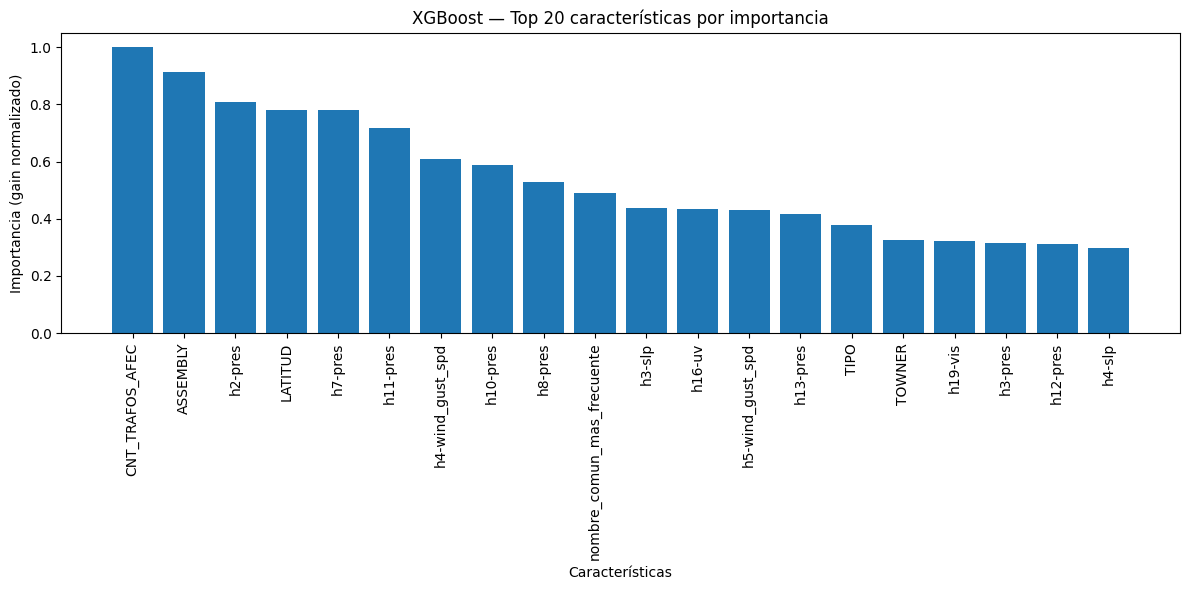

In [19]:
dtrain = xgb.DMatrix(Xtr, label=y_train_1d)
dvalid = xgb.DMatrix(Xva, label=y_valid_1d)
dtest  = xgb.DMatrix(Xte,  label=y_test_1d)

# Parámetros XGBoost para regresión en GPU
params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",   # <- ya no 'gpu_hist'
    "device": "cuda",        # <- activa GPU
    "max_depth": 8,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "random_state": 42,
    "eval_metric": "rmse",
    "verbosity": 0           # <- silencia logs internos de XGB
}

num_boost_round = 3000
early_stopping_rounds = 100

watchlist = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=0
)

# Predicciones con el mejor número de iteraciones
y_pred_valid = booster.predict(dvalid, iteration_range=(0, booster.best_iteration+1))
y_pred_test  = booster.predict(dtest,  iteration_range=(0, booster.best_iteration+1))

r2_v = regression_metrics(y_valid_1d, y_pred_valid)[2]
r2_t = regression_metrics(y_test_1d,  y_pred_test)[2]

print(f"[XGB GPU] Test  -> R2={r2_t:.4f}")
# Obtener nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Importancias por ganancia
imp = booster.get_score(importance_type="gain")  # {'f0':..., 'f12':...}
scores = np.zeros(len(feature_names), dtype=np.float32)
for k, v in imp.items():
    if k.startswith('f'):
        idx = int(k[1:])  # 'f10' -> 10
        if 0 <= idx < scores.size:
            scores[idx] = v

# Fallback si 'gain' está vacío
if not np.any(scores):
    imp = booster.get_score(importance_type="weight")
    for k, v in imp.items():
        if k.startswith('f'):
            idx = int(k[1:])
            if 0 <= idx < scores.size:
                scores[idx] = v

# Normalizar para una escala [0,1] legible
if scores.max() > 0:
    scores = scores / scores.max()

# Seleccionar Top-20
TOPK = 20
order = np.argsort(scores)[::-1][:TOPK]
top_names = [feature_names[i] for i in order]
top_scores = scores[order]

# Gráfico de barras (vertical), eje x con nombres rotados 90°
plt.figure(figsize=(12, 6))
plt.bar(range(TOPK), top_scores)
plt.xticks(range(TOPK), top_names, rotation=90)
plt.ylabel("Importancia (gain normalizado)")
plt.xlabel("Características")
plt.title("XGBoost — Top 20 características por importancia")
plt.tight_layout()
plt.show()

## TabNet (Attentive Neural Networks for Tabular Data)

* TabNet es un modelo de *deep learning* para datos tabulares que combina **atención secuencial** y **selección esparsa de variables**, logrando buen rendimiento en regresión/clasificación con interpretabilidad nativa y entrenamiento en GPU (PyTorch/TF).

* Su principio consiste en **decisiones en pasos**: en cada paso $t$, un *attentive transformer* produce una máscara $\mathbf{M}^{(t)}$ (vía *sparsemax*) que **selecciona un subconjunto de características**; un *decision transformer* procesa solo esas columnas y genera una contribución. Las salidas de todos los pasos se **agregan aditivamente** para la predicción, mientras una regularización de **esparsidad** limita el número de variables usadas y controla su reuso ($\gamma$).

* A diferencia de los ensambles de árboles, TabNet **aprende representaciones no lineales** y **selección de variables dependiente del contexto** en un solo modelo end-to-end; además, ofrece **importancias globales** (promedio de máscaras) y **explicaciones locales** por muestra, maneja variables categóricas mediante **embeddings**, soporta *early stopping* y *mini-batches*, y se beneficia de la aceleración en GPU para grandes volúmenes de datos.

![RandomForest](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*XWoroyIDVa_ACzcKmigwOQ.png)


In [20]:
par = {
    'n_d': 144, 'n_a': 144, 'n_steps': 10, 'gamma': 94.66997047890686,
    'lambda_sparse': 2.8731055681649033e-11, 'batch_size': 4096,
    'mask_type': 'entmax', 'emb': 46, 'momentum': 0.023136657722718557,
    'learning_rate': 0.03017683806097458, 'weight_decay': 4.1323153592424204e-05,
    'scheduler_gamma': 0.44928231250804757, 'step_size': 15,
    'virtual_batch_size': 1024, 'optimizer_type': 'rmsprop',
    'p': 0.9806570564809924
}
best_params =  par
# Asignación de parámetros
n_d = best_params['n_d']
n_a = best_params['n_a']
n_steps = best_params['n_steps']
gamma = best_params['gamma']
lambda_sparse = best_params['lambda_sparse']
mask_type = best_params['mask_type']
batch_size = best_params['batch_size']
emb = best_params['emb']
p = best_params['p']
momentum = best_params['momentum']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
scheduler_gamma = best_params['scheduler_gamma']
step_size = best_params['step_size']
virtual_batch_size = best_params['virtual_batch_size']
optimizer_type = best_params['optimizer_type']

# Configurar optimizador según el tipo seleccionado
if optimizer_type == 'adam':
    optimizer_fn = torch.optim.Adam
    optimizer_params = {'lr': learning_rate, 'weight_decay': weight_decay}
elif optimizer_type == 'adamw':
    optimizer_fn = torch.optim.AdamW
    optimizer_params = {'lr': learning_rate, 'weight_decay': weight_decay}
elif optimizer_type == 'sgd':
    optimizer_fn = torch.optim.SGD
    optimizer_params = {'lr': learning_rate, 'momentum': momentum, 'weight_decay': weight_decay}
elif optimizer_type == 'rmsprop':
    optimizer_fn = torch.optim.RMSprop
    optimizer_params = {'lr': learning_rate, 'momentum': momentum, 'weight_decay': weight_decay}

# Definición de la técnica de aumento de datos
aug = RegressionSMOTE(p=p)

# Identificación de columnas categóricas y sus dimensiones
cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]
cat_dims = [categorical_dims[f] for f in features if f in CATEGORICAL_COLUMNS]
cat_emb_dim = [min(emb, (dim + 1) // 2) for dim in cat_dims]
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Valores de lambda_sparse para iterar
lambda_values = [lambda_sparse]

# Listas para guardar las máscaras y matrices de explicación de cada iteración
all_masks = []
all_explain_matrices = []

for iteration, lambda_sparse in enumerate(lambda_values):
    print(f"Iteración {iteration + 1}, lambda_sparse={lambda_sparse}")

    # Inicialización del modelo TabNetRegressor
    clf =  CustomTabNetRegressor(
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        cat_idxs=cat_idxs,
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        mask_type=mask_type,
        optimizer_fn=optimizer_fn,
        optimizer_params=optimizer_params,
        scheduler_params={"gamma": scheduler_gamma, "step_size": step_size},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        momentum=momentum,
        verbose=True
    )

    # Entrenar el modelo
    clf.fit(
        X_train=X_train,
        y_train=y_train[:,0:1],
        eval_set=[(X_train, y_train[:,0:1]), (X_valid, y_valid[:,0:1])],
        eval_name=['train', 'valid'],
        eval_metric=['mae'],
        loss_fn=my_r2_score_fn,
        max_epochs=2,
        patience=50,
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        num_workers=1,
        drop_last=False,
        augmentations=aug,
    )



Iteración 1, lambda_sparse=2.8731055681649033e-11


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1084226.82911| train_mae: 1.22996 | valid_mae: 1.2298  |  0:00:11s
epoch 1  | loss: 611.66716| train_mae: 4.72296 | valid_mae: 4.72039 |  0:00:20s
Stop training because you reached max_epochs = 2 with best_epoch = 0 and best_valid_mae = 1.2298


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [21]:
clf = torch.load("/content/CHEC/model.pth",weights_only=False)

y_pred=clf.predict(X_test)
y_pred_=np.tile(y_pred, (1, 2))
y_pred_ = scaler.inverse_transform(y_pred_)
y_test_ = scaler.inverse_transform(y_test)
# Plot 2
r2_1 = r2_score(y_test_[:, 0], y_pred_[:, 0])
print(f" Test  -> R2={r2_1:.4f}")

 Test  -> R2=0.8832


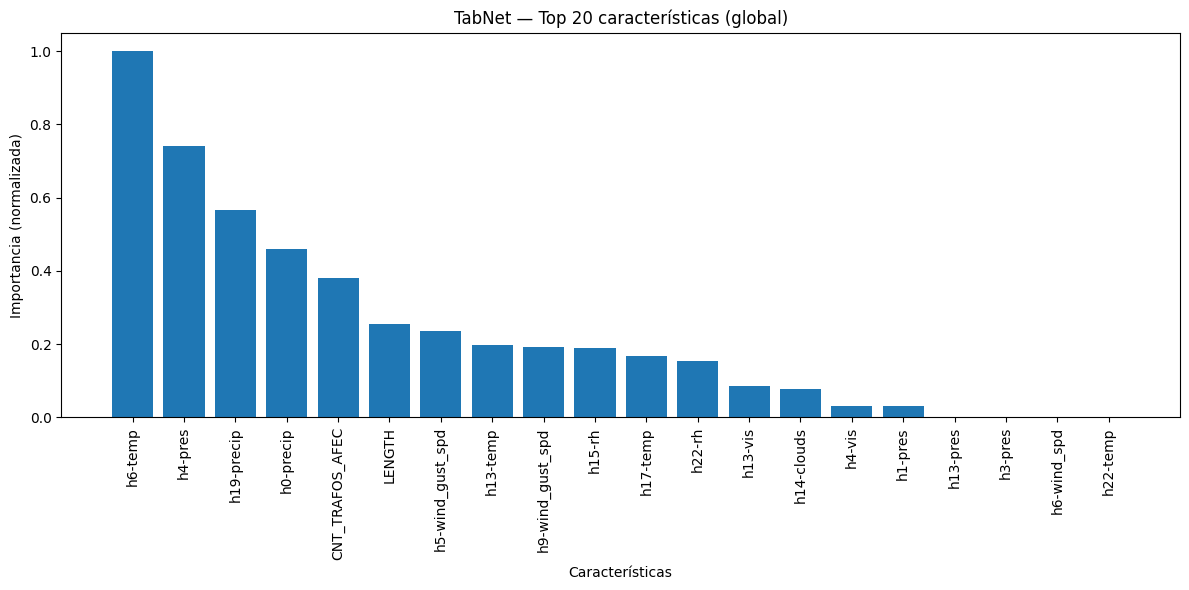

In [22]:

# Importancias globales del modelo (promedio de máscaras de atención)
imp = getattr(clf, "feature_importances_", None)
if imp is None:
    raise ValueError("clf.feature_importances_ no está disponible; entrena el modelo antes de graficar.")

imp = np.asarray(imp, dtype=float)

# Nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(len(imp))]

# Normalizar a [0, 1] para lectura
imp_norm = imp / imp.max() if imp.max() > 0 else imp

# Top-20
TOPK = 20
order = np.argsort(imp_norm)[::-1][:TOPK]
top_names = [feature_names[i] for i in order]
top_scores = imp_norm[order]

# Gráfico de barras (como la primera gráfica)
plt.figure(figsize=(12, 6))
plt.bar(range(TOPK), top_scores)
plt.xticks(range(TOPK), top_names, rotation=90)
plt.ylabel("Importancia (normalizada)")
plt.xlabel("Características")
plt.title("TabNet — Top 20 características (global)")
plt.tight_layout()
plt.show()


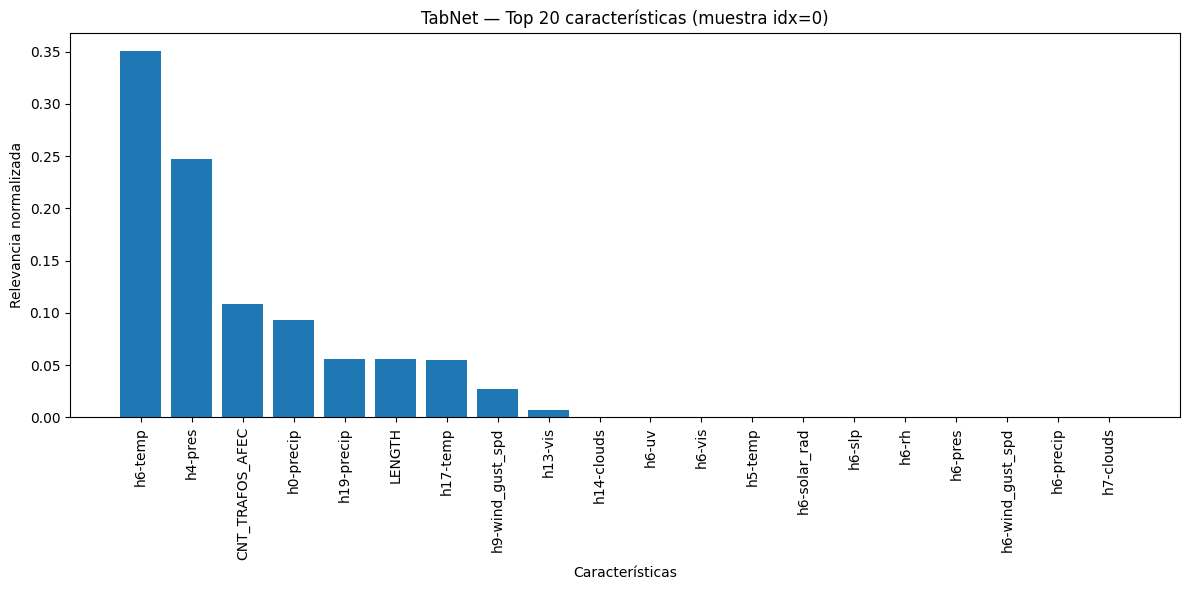

In [23]:
# Relevancia local por muestra con TabNet (pytorch-tabnet)
# Se asume que tienes un TabNetRegressor entrenado llamado `clf`
# y una lista `features` con los nombres de columnas en el mismo orden que X_*.

# 1) Selecciona algunas muestras (por índice sobre X_test)
idx = [0]  # cámbialos por las filas que te interesen
X_samples = X_test[idx]

# 2) Explicaciones locales
# M_explain: (n_muestras, n_features)
# masks: lista de largo n_steps con matrices (n_muestras, n_features) por paso
M_explain, masks = clf.explain(X_samples)

# 3) Normaliza por fila para leer como “peso relativo” (opcional pero útil)
M_norm = M_explain / (M_explain.sum(axis=1, keepdims=True) + 1e-12)

# 4) Nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(M_norm.shape[1])]

TOPK = 20

# 5) Gráfico por muestra (una figura por muestra, barras con rotación 90°)
for r, row in enumerate(M_norm):
    order = np.argsort(row)[::-1][:TOPK]
    names = [feature_names[i] for i in order]
    scores = row[order]
    plt.figure(figsize=(12, 6))
    plt.bar(range(TOPK), scores)
    plt.xticks(range(TOPK), names, rotation=90)
    plt.ylabel("Relevancia normalizada")
    plt.xlabel("Características")
    plt.title(f"TabNet — Top {TOPK} características (muestra idx={idx[r]})")
    plt.tight_layout()
    plt.show()
